In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# 1 Cargar datos del csv
data = pd.read_csv('27SujetosLecturasEMG/S26_2000_LecturasTrain.csv', header=None)
X = data.values  # 10000 muestras x 10 características

# Se especifican rangos
y = np.zeros(10000)
y[1:2000] = 0    # Movimiento 1 (reposo)
y[2001:4000] = 1 # Movimiento 2 (Abduccion de los dedos)
y[4001:6000] = 2 # Movimiento 3 (Dedos flexionados juntos)
y[6001:8000] = 3 # Movimiento 4 (señala con índice)
y[8001:10000] = 4 # Movimiento 5 (envoltura media)

# 2. Validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []  # lista para guardar resultados

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convertir etiquetas a one-hot encoding
    y_train = to_categorical(y_train, num_classes=5)
    y_test = to_categorical(y_test, num_classes=5)

    # Normalizar datos
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Definir modelo
    model = Sequential([
        Input(shape=(10,)),
        Dense(30, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(0.002)), Dropout(0.25),
        Dense(15, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(0.001)), Dropout(0.25),
        Dense(5, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros')
    ])

    # Compilar modelo
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Entrenar modelo
    history = model.fit(X_train, y_train,
                        batch_size=32,
                        epochs=50,
                        verbose=0)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Guardar resultados en lista
    results.append({
        'Fold': fold,
        'Accuracy': accuracy * 100,
        'Loss': loss
    })
    print(f'Fold {fold} → Accuracy: {accuracy*100:.2f}% | Loss: {loss:.4f}')

# Convertir resultados en DataFrame
df_results = pd.DataFrame(results)

# Mostrar resumen
print("\nResultados por fold:")
print(df_results)
print("\nPromedio de precisión:", df_results['Accuracy'].mean())
print("Desviación estándar:", df_results['Accuracy'].std())

Fold 1 → Accuracy: 89.30% | Loss: 0.3672
Fold 2 → Accuracy: 89.85% | Loss: 0.3433
Fold 3 → Accuracy: 90.30% | Loss: 0.3360
Fold 4 → Accuracy: 90.70% | Loss: 0.3166
Fold 5 → Accuracy: 88.60% | Loss: 0.3611

Resultados por fold:
   Fold   Accuracy      Loss
0     1  89.300001  0.367161
1     2  89.850003  0.343348
2     3  90.300000  0.335954
3     4  90.700001  0.316648
4     5  88.599998  0.361078

Promedio de precisión: 89.75000023841858
Desviación estándar: 0.827648134947955


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


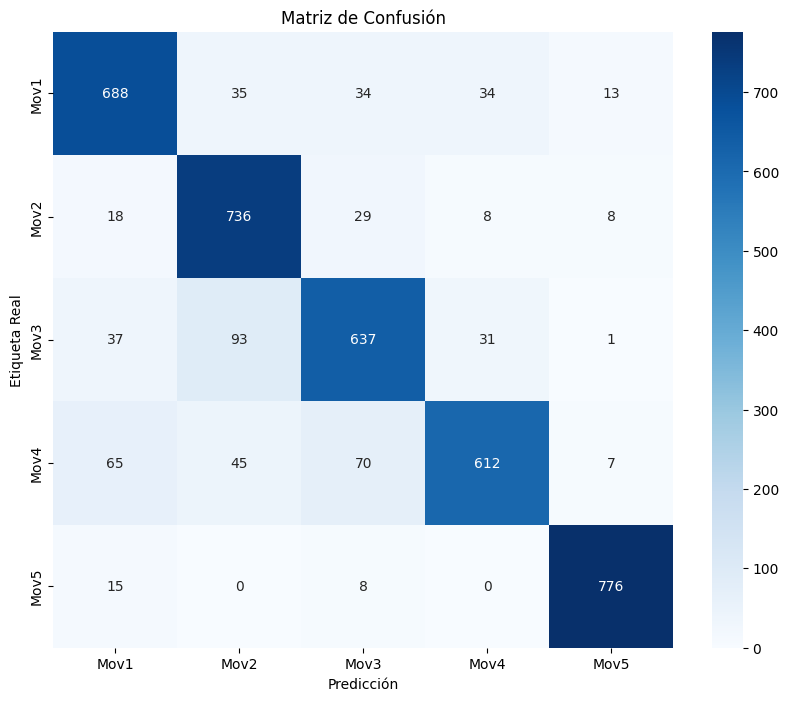


Reporte de Clasificación:
              precision    recall  f1-score   support

        Mov1       0.84      0.86      0.85       804
        Mov2       0.81      0.92      0.86       799
        Mov3       0.82      0.80      0.81       799
        Mov4       0.89      0.77      0.82       799
        Mov5       0.96      0.97      0.97       799

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000


Precisión Global: 86.22%


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model


test_data = pd.read_csv('27SujetosLecturasEMG/S26_800_LecturasTest.csv', header=None)
X_test = test_data.values

y_test = np.zeros(4000)  #4000 muestras en total
y_test[1:800] = 0       # Movimiento 1 (reposo)
y_test[801:1600] = 1    # Movimiento 2 (Abducción de los dedos)
y_test[1601:2400] = 2    # Movimiento 3 (dedos flexionados)
y_test[2401:3200] = 3    # Movimiento 4 (señala con índice)
y_test[3201:4000] = 4    # Movimiento 5 (envoltura media)


X_test = scaler.transform(X_test)  

#  predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

#  matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# grafica
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mov1', 'Mov2', 'Mov3', 'Mov4', 'Mov5'],
            yticklabels=['Mov1', 'Mov2', 'Mov3', 'Mov4', 'Mov5'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()


print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=['Mov1', 'Mov2', 'Mov3', 'Mov4', 'Mov5']))

# 8. Precisión general
accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"\nPrecisión Global: {accuracy*100:.2f}%")